Variational AutoEncoders

Variational autoencoder was proposed in 2013 by Knigma and Welling at Google and Qualcomm. A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space. Thus, rather than building an encoder that outputs a single value to describe each latent state attribute, we’ll formulate our encoder to describe a probability distribution for each latent attribute.

It has many applications such as data compression, synthetic data creation etc.

Architecture:

Autoencoders are a type of neural network that learns the data encodings from the dataset in an unsupervised way. It basically contains two parts: the first one is an encoder which is similar to the convolution neural network except for the last layer. The aim of the encoder to learn efficient data encoding from the dataset and pass it into a bottleneck architecture. The other part of the autoencoder is a decoder that uses latent space in the bottleneck layer to regenerate the images similar to the dataset. These results backpropagate from the neural network in the form of the loss function.

Variational autoencoder is different from autoencoder in a way such that it provides a statistic manner for describing the samples of the dataset in latent space. Therefore, in variational autoencoder, the encoder outputs a probability distribution in the bottleneck layer instead of a single output value.

Mathematics behind variational autoencoder:

Variational autoencoder uses KL-divergence as its loss function, the goal of this is to minimize the difference between a supposed distribution and original distribution of dataset.

Suppose we have a distribution z and we want to generate the observation x from it.  In other words, we want to calculate $p(z|x)$. We can do it by following way: $p(z|x)=\frac{p(x|z)p(z)}{p(x)}.$

But, the calculation of $p(x)$ can be quite difficult $p(x)=\int p(x|z)p(z) dz.$

This usually makes it an intractable distribution. Hence, we need to approximate $p(z|x)$ to $q(z|x)$ to make it a tractable distribution. To better approximate $p(z|x)$ to $q(z|x)$, we will minimize the KL-divergence loss which calculates how similar two distributions are:
$\min KL(q(z|x)||p(z|x))$.

By simplifying, the above minimization problem is equivalent to the following maximization problem:

$E_{q(z|x)} \log p(x|z) - KL(q(z|x)||p(z))$

The first term represents the reconstruction likelihood and the other term ensures that our learned distribution q is similar to the true prior distribution p.
 

Thus our total loss consists of two terms, one is reconstruction error and other is KL-divergence loss:

$Loss = L(x,\hat{x}) + \sum_j KL(q_j(z|x)||p(z))$

Implementation:

 

In this implementation, we will be using the Fashion-MNIST dataset, this dataset is already available in keras.datasets API, so we don’t need to add or upload manually.

 

First, we need to import the necessary packages to our python environment. we will be using Keras package with tensorflow as a backend.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [2]:
class Sampling(Layer):
 
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# Define Encoder Model
latent_dim = 2
 
encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [4]:
# Define Decoder Architecture
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [5]:
# this class takes encoder and decoder models and
# define the complete variational autoencoder architecture
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super(VAE, self).__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder

	def train_step(self, data):
		if isinstance(data, tuple):
			data = data[0]
		with tf.GradientTape() as tape:
			z_mean, z_log_var, z = encoder(data)
			reconstruction = decoder(z)
			reconstruction_loss = tf.reduce_mean(
				keras.losses.binary_crossentropy(data, reconstruction)
			)
			reconstruction_loss *= 28 * 28
			kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
			kl_loss = tf.reduce_mean(kl_loss)
			kl_loss *= -0.5
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		return {
			"loss": total_loss,
			"reconstruction_loss": reconstruction_loss,
			"kl_loss": kl_loss,
		}


In [7]:
# load fashion mnist dataset from keras.dataset API
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)
# expand dimension to add a color map dimension
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

# compile and train the model
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 100, batch_size = 64)


1094/1094 [==============================] - 69s 63ms/step - loss: 276.8902 - reconstruction_loss: 273.5193 - kl_loss: 3.3709


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (10).

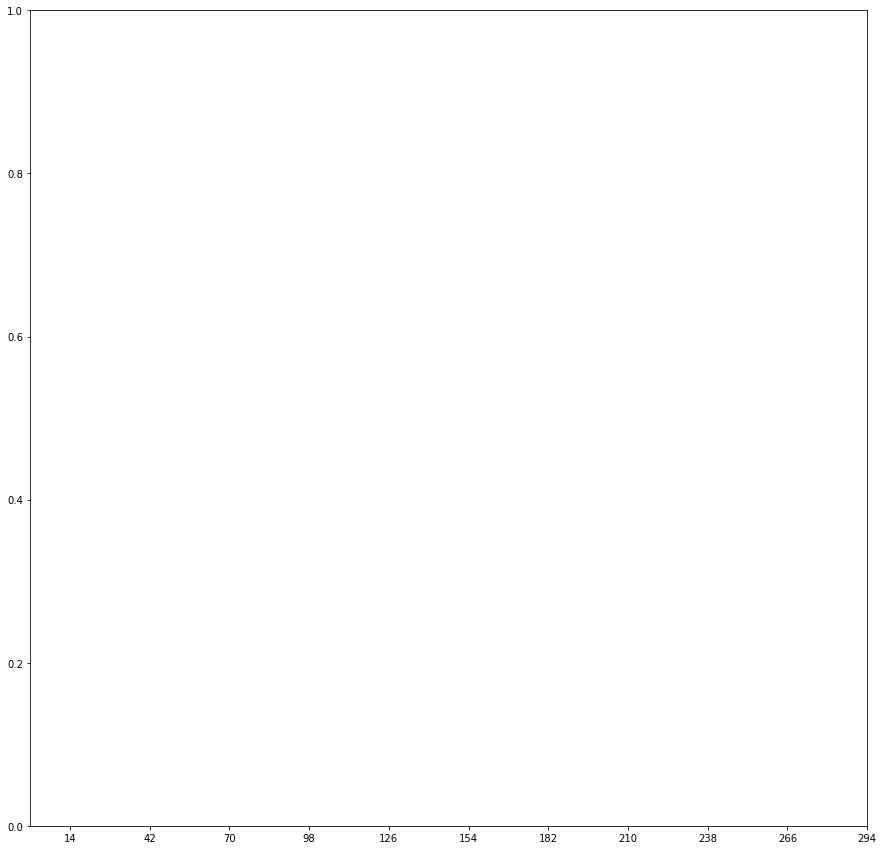

In [8]:
def plot_latent(encoder, decoder):
	# display a n * n 2D manifold of images
	n = 10
	img_dim = 28
	scale = 2.0
	figsize = 15
	figure = np.zeros((img_dim * n, img_dim * n))
	# linearly spaced coordinates corresponding to the 2D plot
	# of images classes in the latent space
	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			z_sample = np.array([[xi, yi]])
			x_decoded = decoder.predict(z_sample)
			images = x_decoded[0].reshape(img_dim, img_dim)
			figure[
				i * img_dim : (i + 1) * img_dim,
				j * img_dim : (j + 1) * img_dim,
			] = images

	plt.figure(figsize =(figsize, figsize))
	start_range = img_dim // 2
	end_range = n * img_dim + start_range + 1
	pixel_range = np.arange(start_range, end_range, img_dim)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	plt.xticks(pixel_range, sample_range_x)
	plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap ="Greys_r")
	plt.show()


plot_latent(encoder, decoder)


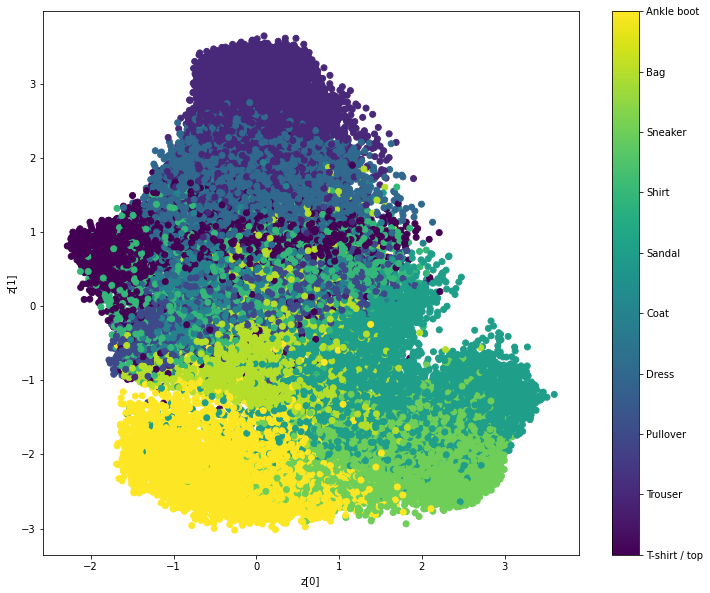

In [9]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
